In [1]:
cd ..

/home/jovyan/work/dsi-plus-2/Capstone


In [2]:
%run __init__.py
%matplotlib inline

## EDA on ABBV Stock

In [3]:
ABBV = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS/ABBV_data.csv')

In [4]:
ABBV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 50 columns):
Unnamed: 0                     1177 non-null int64
Date                           1177 non-null object
Open                           1176 non-null float64
High                           1176 non-null float64
Low                            1177 non-null float64
Close                          1177 non-null float64
Volume                         1177 non-null int64
Name                           1177 non-null object
Acc/Dist_ROC_1                 1170 non-null float64
ADX_14_50                      1116 non-null float64
ATR_14                         1164 non-null float64
BollingerB_5                   1173 non-null float64
Bollinger%b_5                  1173 non-null float64
BollingerB_20                  1158 non-null float64
Bollinger%b_20                 1158 non-null float64
Copp_10                        1155 non-null float64
Chaikin                        1169 non-null float6

In [5]:
ABBV.Date = pd.to_datetime(ABBV.Date)
ABBV = ABBV.set_index(ABBV.Date)
ABBV = ABBV.drop("Unnamed: 0", axis = 1)

#### Plot of Historical Close Prices

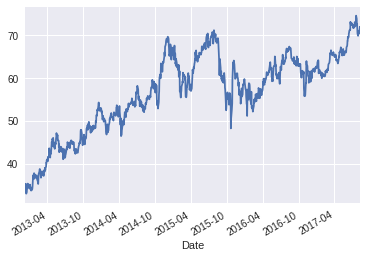

In [6]:
ABBV.Close.plot()

#### Data Cleaning

In [7]:
ABBV.iloc[:, 8:] = ABBV.iloc[:, 8:].shift()
ABBV = ABBV.dropna()
ABBV = ABBV.drop("Acc/Dist_ROC_1" , axis = 1)

In [8]:
y = ABBV["Close"]
X = ABBV.iloc[:, 6:]

In [9]:
X = X.drop("Name", axis=1)

In [10]:
y.isnull().sum()

0

In [11]:
X.isnull().sum()

ADX_14_50                      0
ATR_14                         0
BollingerB_5                   0
Bollinger%b_5                  0
BollingerB_20                  0
Bollinger%b_20                 0
Copp_10                        0
Chaikin                        0
EMA_5                          0
EMA_20                         0
Force_2                        0
KST_10_10_10_15_10_15_20_30    0
MA_5                           0
MA_20                          0
MACD_12_26                     0
MACDsign_12_26                 0
MACDdiff_12_26                 0
MFI_14                         0
Momentum_1                     0
Mass Index                     0
OBV_5                          0
OBV_20                         0
PP                             0
R1                             0
R2                             0
R3                             0
S1                             0
S2                             0
S3                             0
ROC_5                          0
ROC_20    

## PCA Analysis

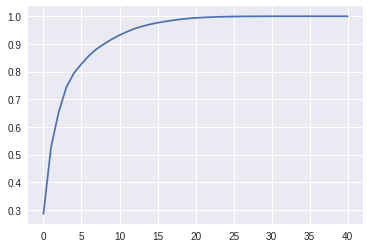

In [12]:
X_sc = StandardScaler().fit_transform(X)

pca = PCA()
pca.fit(X_sc)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

In [13]:
sum(pca.explained_variance_ratio_.cumsum() <= .9)

8

<b> Finding: The first 8 components cover 90% of the explained variance. </b>

## Baseline Analysis

Perform train_test_split on ABBV data.  Since this data is a time series, a custom function has been written to train_test_split based on dates.  For the grid searches below, PCA will use 8 components.

In [14]:
X_train, X_test, y_train, y_test = tts_stock(X, y, test_size=.3)

In [15]:
X.shape, y.shape

((1100, 41), (1100,))

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((770, 41), (330, 41), (770,), (330,))

#### Naive GridSearch on Lasso

In [17]:
lasso_pipe_params = {"pca__n_components": [8],
                     "model__alpha": np.logspace(-2, 3, 5)}

test_model(Lasso(), X_train, y_train, X_test, y_test, naive_flag=True, gs_params=lasso_pipe_params)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
train score: -0.711070616094
test score: -0.626147144107



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


{'model__alpha': 0.01, 'pca__n_components': 8}

#### Naive GridSearch on Ridge

In [18]:
ridge_pipe_params = {"pca__n_components": [8],
                     "model__alpha": np.logspace(-2, 3, 5)}

test_model(Ridge(), X_train, y_train, X_test, y_test, naive_flag=True, gs_params=ridge_pipe_params)

Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
train score: -0.710939888083
test score: -0.620872991774



{'model__alpha': 3.1622776601683795, 'pca__n_components': 8}

#### Naive GridSearch on RandomForestRegressor

In [19]:
rf_pipe_params = {"pca__n_components": [8],
                  "model__n_estimators": [10, 50, 100]}

test_model(RandomForestRegressor(), X_train, y_train, X_test, y_test, naive_flag=True, gs_params=rf_pipe_params)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
train score: -0.319355714286
test score: -1.74297151515



{'model__n_estimators': 100, 'pca__n_components': 8}

## Findings and Next Steps

Lasso and Ridge produce train and test scores in the high 90% range, while RandomForestRegressor produces significantly different train and test scores.  These findings would imply overfitting.

In addition, this naive analysis was performed with the closing price as the target, whereas future analysis will use trading signal as the target.

The most meaningful finding was that the first eight principal components of the selected stock cover 90% of the explained variance, so a similar number of principal components will be utilized when creating the final model.